# Overview of Class Imbalance
> Note: This is a preliminary document that is supposed to give an overview of the class imbalance problem and suggest some solutions for internal use among course instructors. A more pedagogical version with code snippets or an extended blog post can be built on it later on for external use. 

## A. Why class imbalance is a problem?

Training an ML algorithm with imbalanced dataset might **create a learning bias** against the minority class(es) and consequently **affect the predictive performance** on such class(es). This is because most of the ML algorithms inherently assume balanced dataset and equal costs of errors (i.e. the cost of a false alarm is the same as the cost of a miss). Furthermore, the **performance evaluation under class-imbalance becomes more challenging**, especially when different errors are perceived with different degrees of importance (e.g. in medical applications the cost of a miss is much higher than that of a false alarm while diagnosing a fatal disease, and such costs can not be always quantified). In this case standard metrics such as accuracy, and sometimes AUROC, become less informative and even misleading in some high imbalance situations. Therefore, it is very essential to understand the effects of class imbalance on learning algorithms and examine how one can mitigate such effects and perform informative evaluations. We will start first by investigating the problems arising with the class imbalance.

### A.1 Prior bias (in the case of prior distribution drift between training and testing): <a name="A1"></a>

This is a problem arising in special circumstances where the class imbalance is not expected to be the same during training and testing. For instance, assume we are running a binary classification on cats and dogs images. For some reason, during the data collection, we were able to build a training dataset with 80% cats and 20% dogs. However, during testing we are expecting that our classifier will be tested on a more balanced situation where 50% of the images belong to cats and 50% belong to dogs. In such case, and assuming our classifier has *enough learning capacity*, the algorithm will inherently learn the wrong priors and lead to biased predictions at the test time.

Formally, let $x$ be the input, e.g. a cat/dog image, of a binary classifier $f(\cdot)$. You can think of $f(\cdot)$ being a logistic regression or a neural network mapping $x$ to $f(x)$. In such case, $f(x)$ represents the posterior probability of $x$ being in class $C1$, say cats, where 

\begin{equation}
f(x) = p(C1/x) \propto p(x/C_1) \times p(C1).
\end{equation}

The prediction is then made by choosing the class with higher posterior (if $f(x)>1/2$, which means $p(C1/x) > p(C2/x)$,  then it is a cat, otherwise dog).

> <sub>
In the case of logistic regression, one can easily link the posterior probability to the parameters ($w$ and $b$)
\begin{align}
p(C_1|x) = \frac{p(x|C_1)p(C_1)}{p(x)} = \frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}= \frac{1}{1 + \frac{p(x|C_2)p(C_2)}{p(x|C_1)p(C_1)}}
= \frac{1}{1 + \exp\left(-\ln\frac{p(x|C_1)p(C_1)}{p(x|C_2)p(C_2)}\right)} = \frac{1}{1 + \exp\left(-(w^Tx + b)\right)} = \sigma(w^Tx + b).
\end{align}
 </sub>

Assuming that the classifier has enough capacity, it will learn the *biased* training prior $p(C1)=0.8$. If we expect that such prior distribution does not hold during test time, we need to mitigate this problem. This can be done during training time (re-balance dataset via sampling/data augmentation, use penalized models) or at the test time (correct the output probability, adjust threshold) as we will see later.

### A.2 Poor predictive performance on the minority class:

This is a more general problem that holds even if the imbalance persists during the test time. Take for example the prediction of a fatal rare disease: the dataset is expected to be imbalanced both during training and testing, and there is no issue of distribution drift here. However, the imbalance can still affect the learning task. This is because the relatively few instances in the minority class are not enough for the algorithm to fully discover the feature space and learn the appropriate rule. Therefore, the problem here is not in learning a biased prior as in the previous section, but rather in the ability to learn the whole posterior probability.

Take the Gaussian naive Bayes classifier as an example. In case of few instance in one of the classes, we will get a poor estimation for both the prior and the Gaussian likelihood, and hence a poor performance (high generalization error).

> Note that in the previous section we had assumed that the learning algorithm has *enough learning capacity* in order to filter out this effect and focus on the prior's bias.

In order to mitigate such problem, one has to adjust the data or the model during training (data augmentation, penalized models). However, re-balancing the data or penalizing the machine learning model can create an *artificial bias* that needs to be corrected during test time. More information on this in the sequel.

### A.3 Less informative evaluation metrics:

The accuracy metric is meaningful for a relatively balanced dataset and for the cases where the two types of errors have the same cost (cost of false alarm = cost of miss). However, for imbalanced datasets the accuracy metrics can become misleading by giving an inflated measure that can be easily beaten by a dummy classifier. Similarly for other evaluation metrics such as the false positive rate (FPR) used in the ROC.

Lets first review different evaluation metrics in a binary classification set up:
- Accuracy $= (TP + TN)/(P+N) = (TP + TN)/(TP + FN + TN + FP)$
- TPR or recall $= TP/P = TP/(TP+FN)$
- FPR = $FP/N = FP/(FN+TN)$
- precision $= TP/(TP+FP)$

The problem with the imbalance dataset is that the majority class (usually the negative class) is overwhelming. Hence, with any reasonable classifier the $TN$ term will dominate the numerator and denominator in the accuracy and makes it close to $1$. Similarly for the false positive rate (FPR) where the dominating $TN$ term makes it always close to zero. Therefore, the accuracy and the ROC might be misleading in assessing the performance under class imbalance.

I ideally, we want both the $FN$ and $FP$ terms to be small without including the dominating $TN$. Hence, **it is a good practice to look at the precision and recall** which are not sensitive to the class imbalance through the $TN$ term. One way to combine these two metrics is via a harmonic mean F-1 score. This is of course under the assumptions that both types of error have the same cost. If not, one can use a weighted version of such score, e.g. F-$\beta$ score. In general, it is always recommended to look at the entire confusion matrix in such cases.

More info on F-1 score with useful visualizations [here](https://github.com/MhDia/MLteaching/blob/master/T2_F1score.ipynb).

> **Note:** The precision and recall, and hence the F-1 score, are less sensitive to class imbalance under the convention that the majority class in the negative class (i.e. the $TN$ term is relatively large than the $TP$ term). In case of a flip of convention, the precision and recall might become misleading and one needs to look at their counterpart that excludes the $TP$ terms. Therefore, it is better to stick with the convention for class imbalance (majority class being the negative class labeled by $0$ for binary classification in `sklearn`).  

## B. How to mitigate the class imbalance problem?

The effects of the class imbalance might vary based on the degree of imbalance, the amount of available data, and the type of the ML model and learning algorithm used. In some cases, one might get satisfactory performance results via standard hyper-parameter tuning and without considering further modifications in the training pipeline. However, in many other cases, especially under high imbalance and limited amount of data, one needs to address the class imbalance during the training and/or testing phases. Below are common techniques to mitigate the class imbalance problem. Such techniques can be used separately or in conjunction.

### B.1 Re-balance training dataset:<a name="B1"></a>
Try to re-balance the training dataset in favor of the minority class via the following techniques: 
- Collect more data for the minority class (if possible)
- Data augmentation of the minority class (creating synthetic samples/features, e.g. [SMOTE](https://arxiv.org/pdf/1106.1813.pdf))
- Up-sample the minority class during training
- Down-sample the majority class during training

> Note that one needs to be careful while re-balancing the training dataset. Overdoing this technique might create an *artificial bias* in the [training prior](#A1) that needs to be corrected during test time (see [B.3](#B3) below).

### B.2 Use penalized models for training (cost-sensitive models):<a name="B2"></a>
Penalize the minority class more than the majority class by adjusting the cost function. For example, if class A is twice less frequent than class B in the training dataset, define a cost function that penalizes class A more than class B. This way will make the ML model focus more on the minority class in order to compensate for the imbalance. This can be easily done in `sklearn` models by changing the `class_weight` parameter (alternatively, one can change the `sample_weight` in the `fit` method). The 'balanced' mode in `class_weight` automatically adjusts the cost function by picking weights representing the inverse class frequencies. One can manually choose such weights and tune them during hyper-parameters tuning on the validation set. Penalized models have similar, but not exactly the same effect as the techniques mentioned in [B.1](#B1) above.

> Similarly as in [B.1](#B1), one needs to carefully choose the weights in order not to create an *artificial bias* in the training prior.

### B.3 Adjust the predictions during testing:<a name="B3"></a>
This technique is mainly used to correct the prior bias due to drift in distribution (see [A.1](#A1)) or due to artificial bias added during training. The idea is to adjust the output probabilities, or alternatively the decision threshold, at the prediction time in order to account for the bias. Take for example the binary classification problem, an ML model such as logistic regression is trained to output a prediction representing the posterior probability of an input being in class 1 or 0. The decision is then made based on the magnitude of the probabilities. If $p(x/C_1)>p(x/C_0)$ then we decide that x belongs to class 1, otherwise it belongs to class 0. The default threshold used for such binary classification is $\alpha = 1/2$, i.e. if $p(x/C_1)>\alpha$ it is believed that $x$ is in class 1. Such threshold is made based on the assumption that the prior distributions don't change between training and testing. However, this assumption might be violated due to a drift in distribution or artificial bias added during training. In this case one needs to modify the threshold $\alpha$ during testing. If the prior bias is numerically quantified, which not usually possible, one can then compute the optimal $\alpha$ and use it at the test time. In practice, such threshold can be tuned during hyper-parameter tuning.

### B.4 Use appropriate evaluation metrics:
used in conjunction with all the one above
- Precision/recall curve
- F-1 score (or weighted version)
- Confusion matrix
- avoid misleading metrics: accuracy, FPR, TNR (or specificity/selectivity), or any metric where the $TN$ term can dominate.

## Demo

In [325]:
# import the necessary module from scikit learn
from sklearn.datasets import load_breast_cancer, load_digits, load_iris, load_wine, fetch_kddcup99
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [285]:
# load the data
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv', header=None)
X = df.values[:, :-1].astype(float)
y = df.values[:, -1]
y = y-1 #convert labels from 1/2 format to 0/1 format

In [286]:
sum(y)/len(y)

0.2647058823529412

In [287]:
# split data for traing and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [288]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [331]:
# train a linear binary classifier
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [332]:
# predict the labels of the train/test dataset
y_train_pred = model.predict(X_train)
y_train_pob = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_pob = model.predict_proba(X_test)

In [333]:
# compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
##print("confusion matrix: \n", conf_mat)
# pritn the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  69 FP =  5 
FN =  20 TP =  7


In [334]:
acc = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auroc = roc_auc_score(y_test, y_test_pred)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.75 
 Recall =  0.26 
 Precision =  0.58 
 F-1 score =  0.36 
 AUROC =  0.6


In [335]:
#report = classification_report(y_true=y_test, y_pred=y_test_pred)
#print(report)

In [381]:
model = LogisticRegression(solver='liblinear', class_weight={0:1,1:2.2})
model.fit(X_train, y_train, )

LogisticRegression(C=1.0, class_weight={0: 1, 1: 2.2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [364]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train, )

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [382]:
# predict the labels of the train/test dataset
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

In [383]:
# compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
##print("confusion matrix: \n", conf_mat)
# pritn the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  63 FP =  11 
FN =  17 TP =  10


In [384]:
acc = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auroc = roc_auc_score(y_test, y_test_pred)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.72 
 Recall =  0.37 
 Precision =  0.48 
 F-1 score =  0.42 
 AUROC =  0.61


In [340]:
#report = classification_report(y_true=y_test, y_pred=y_test_pred)
#print(report)

In [341]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_prob[:, 1])

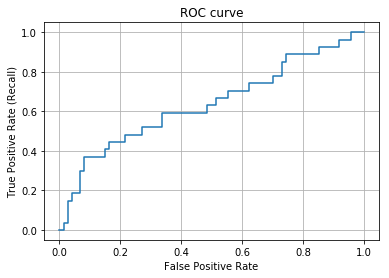

In [342]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC curve')
plt.grid()
plt.show()

In [343]:
pd.DataFrame({
    'fpr': fpr,
    'tpr (recall)': tpr,
    'thresholds': thresholds
})

,fpr,tpr (recall),thresholds
0,0.000000,0.000000,1.914841
1,0.013514,0.000000,0.914841
2,0.013514,0.037037,0.903128
3,0.027027,0.037037,0.891186
4,0.027027,0.148148,0.840411
5,0.040541,0.148148,0.828448
6,0.040541,0.185185,0.801226
7,0.067568,0.185185,0.798400
8,0.067568,0.296296,0.758638
9,0.081081,0.296296,0.698940


In [344]:
prob_ratio = y_test_prob[:,1]/y_test_prob[:,0]

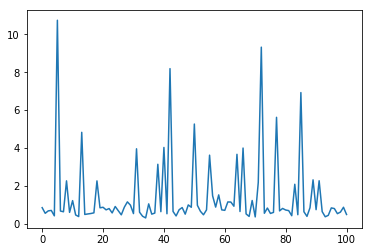

In [345]:
plt.plot(prob_ratio)

In [346]:
y_test_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [347]:
prob_ratio_corr = prob_ratio/3

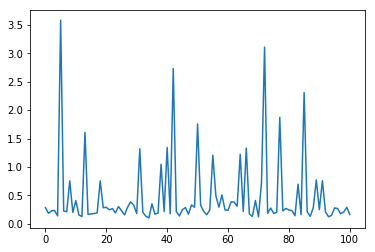

In [348]:
plt.plot(prob_ratio_corr)

In [349]:
y_test_pred_corr =  (prob_ratio_corr >1).astype(int)

In [350]:
y_test_pred_corr

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [351]:
sum(y_test_pred)

27

In [352]:
sum(y_test_pred_corr)

13

In [357]:
#report = classification_report(y_true=y_test, y_pred=y_test_pred_corr)
#print(report)

In [358]:
# compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred_corr)
##print("confusion matrix: \n", conf_mat)
# pritn the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  69 FP =  5 
FN =  19 TP =  8


In [359]:
acc = accuracy_score(y_test, y_test_pred_corr)
recall = recall_score(y_test, y_test_pred_corr)
precision = precision_score(y_test, y_test_pred_corr)
f1 = f1_score(y_test, y_test_pred_corr)
auroc = roc_auc_score(y_test, y_test_pred_corr)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.76 
 Recall =  0.3 
 Precision =  0.62 
 F-1 score =  0.4 
 AUROC =  0.61
